# 11 Classes Classifier for Problematic Samples Detection - Assignment 01 (b)
Used the curated dataset from Assignment 01a to train a classifier that can detect problematic samples. Applied the test set where not "problematic" labels are available.

In [58]:
import os
import random
import fiftyone as fo
import fiftyone.zoo as fozoo
import fiftyone.brain as fobrain
from fiftyone import ViewField as F
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import torchvision.transforms.v2 as transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd


In [59]:
def set_seeds(seed=51):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [60]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
BATCH_SIZE = 32
LEARNING_RATE = 0.003
EPOCHS = 10
RELOAD_DATASETS = True
VALIDATION_SPLIT_SIZE = 15 #%
set_seeds(SEED)

In [61]:
if RELOAD_DATASETS:
    if "curated-mnist" in fo.list_datasets():
        fo.delete_dataset("curated-mnist")
    if "curated-mnist-train" in fo.list_datasets():
        fo.delete_dataset("curated-mnist-train")
    if "curated-mnist-validation" in fo.list_datasets():
        fo.delete_dataset("curated-mnist-validation")
    if "mnist-test" in fo.list_datasets():
        fo.delete_dataset("mnist-test")

if "curated-mnist" not in fo.list_datasets():
    dataset_dir = "../data/mnist-curated"
    curated_mnist_dataset = fo.Dataset.from_dir(
        dataset_dir,
        dataset_type=fo.types.ImageClassificationDirectoryTree,
        name="curated-mnist",
    )
    curated_mnist_dataset.persistent = True

else:
    curated_mnist_dataset = fo.load_dataset("curated-mnist")

if "curated-mnist-train" not in fo.list_datasets() or "curated-mnist-validation" not in fo.list_datasets():
    for sample in tqdm(curated_mnist_dataset, desc="Generating train/validation split"):
        sample.tags = ["train"] if random.random() > VALIDATION_SPLIT_SIZE / 100 else ["validation"]
        sample.save()
    train_dataset = curated_mnist_dataset.match_tags("train").clone("curated-mnist-train")
    train_dataset.persistent = True
    validation_dataset = curated_mnist_dataset.match_tags("validation").clone("curated-mnist-validation")
    validation_dataset.persistent = True
else:
    train_dataset = fo.load_dataset("curated-mnist-train")
    validation_dataset = fo.load_dataset("curated-mnist-validation")

if not "mnist-test" in fo.list_datasets():
  test_dataset = fozoo.load_zoo_dataset("mnist", split='test', dataset_name="mnist-test", persistent=True)
else:
  test_dataset = fo.load_dataset("mnist-test")

 100% |█████████████| 60812/60812 [20.1s elapsed, 0s remaining, 2.6K samples/s]      


Generating train/validation split: 100%|██████████| 60812/60812 [00:42<00:00, 1424.62it/s]


Split 'test' already downloaded
Loading 'mnist' split 'test'
 100% |█████████████| 10000/10000 [4.1s elapsed, 0s remaining, 2.6K samples/s]      
Dataset 'mnist-test' created


In [62]:
print(curated_mnist_dataset.count())
print(train_dataset.count())
print(validation_dataset.count())
print(test_dataset.count())

session = fo.launch_app(test_dataset, auto=False, port=5152)
print(session.url)

60812
51618
9194
10000
Session launched. Run `session.show()` to open the App in a cell output.
http://localhost:5152/


In [63]:
data_classes = [str(el) for el in curated_mnist_dataset.distinct("ground_truth.label")]
label_map = {label: idx if not "problematic" in label else 10 for idx, label in enumerate(data_classes)}
print("Data Classes:", label_map)

Data Classes: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9, 'problematic 0 - zero': 10, 'problematic 1 - one': 10, 'problematic 2 - two': 10, 'problematic 3 - three': 10, 'problematic 4 - four': 10, 'problematic 5 - five': 10, 'problematic 6 - six': 10, 'problematic 7 - seven': 10, 'problematic 8 - eight': 10, 'problematic 9 - nine': 10}


In [64]:
class MNISTDataset(Dataset):
  def __init__(self, fiftyone_dataset, image_transforms=None, label_map=None):
    self.image_paths = fiftyone_dataset.values("filepath")
    self.str_labels = fiftyone_dataset.values("ground_truth.label")
    self.image_transforms = image_transforms or transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
    self.dataset_classes = sorted(fiftyone_dataset.distinct("ground_truth.label"))
    self.label_map = label_map or {str_label: index for index, str_label in enumerate(self.dataset_classes)}

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert('L')
    image = self.image_transforms(image) if self.image_transforms else image

    label_str = self.str_labels[idx]
    label_idx = self.label_map[label_str]
    return image, torch.tensor(label_idx, dtype=torch.long)

In [65]:
class ModernLeNet5(nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()

        self.leNet5 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 120, kernel_size=4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        return self.leNet5(x)


In [66]:
def train(model, optimizer, train_loader, criterion, idx=None):
  batch_losses = []
  model.train()
  with tqdm(desc="Train" + (f"(Epoch {idx})" if idx is not None else ""), leave=False, total=len(train_loader)) as pbar:
    for batch in train_loader:
      pbar.update(1)
      optimizer.zero_grad()
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = model(images)
      loss = criterion(outputs, labels)
      batch_losses.append(loss.item())
      loss.backward()
      optimizer.step()
    pbar.write(f"Epoch {str(idx) + ' ' if idx is not None else ''} done")
    pbar.write(f"Avg. Train Loss: {np.mean(batch_losses)}")
  return np.mean(batch_losses)

def validate(model, val_loader, criterion, idx=None):
  batch_losses = []
  correct, total = 0, 0
  model.eval()
  with torch.no_grad(), tqdm(desc="Validation" + (f"(Epoch {idx})" if idx is not None else ""), leave=False, total=len(val_loader)) as pbar:
    for images, labels in val_loader:
      pbar.update(1)
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      logits = model(images)
      correct += (logits.argmax(dim=1) == labels).sum().item()
      total += len(labels)
      loss_value = criterion(logits, labels)
      batch_losses.append(loss_value.item())
    val_loss = np.mean(batch_losses)
    pbar.write(f"Avg. Validation Loss: {val_loss}")
    pbar.write(f"Validation Accuracy: {correct / total}")
  return val_loss, correct / total

def plot_losses(train_losses, validation_losses, show_fun = None):
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(validation_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.xticks(range(0, EPOCHS), range(1, EPOCHS + 1))
  plt.legend()
  plt.title('Training and Validation Loss')
  best_epoch = np.argmin(validation_losses)
  plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
  plt.legend()
  if show_fun is not None:
    show_fun(plt)
  else:
    plt.show()

In [67]:
train_loader = DataLoader(MNISTDataset(train_dataset, label_map=label_map), batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(MNISTDataset(validation_dataset, label_map=label_map), batch_size=BATCH_SIZE, shuffle=False)
model = ModernLeNet5(num_classes=11).to(DEVICE)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Epoch 1  done
Avg. Train Loss: 0.2966801868174617


Avg. Validation Loss: 0.1475400210707297
Validation Accuracy: 0.9581248640417663


Epoch 2  done
Avg. Train Loss: 0.1327652030135707


Avg. Validation Loss: 0.1286667127570177
Validation Accuracy: 0.9642157929084185


Epoch 3  done
Avg. Train Loss: 0.1151466137368438


Avg. Validation Loss: 0.13516071346377126
Validation Accuracy: 0.9635631933869915


Epoch 4  done
Avg. Train Loss: 0.10593795970172733


Avg. Validation Loss: 0.11640318992272114
Validation Accuracy: 0.9676963236893626


Epoch 5  done
Avg. Train Loss: 0.09743510503283657


Avg. Validation Loss: 0.10496832798420049
Validation Accuracy: 0.9708505547095932


Epoch 6  done
Avg. Train Loss: 0.09471960395189667


Avg. Validation Loss: 0.11487868415579151
Validation Accuracy: 0.9705242549488797


Epoch 7  done
Avg. Train Loss: 0.09052779527583095


Avg. Validation Loss: 0.1291768945711485
Validation Accuracy: 0.9667174244072221


Epoch 8  done
Avg. Train Loss: 0.09607597761090804


Avg. Validation Loss: 0.11159330371694093
Validation Accuracy: 0.9708505547095932


Epoch 9  done
Avg. Train Loss: 0.08479455622342096


Avg. Validation Loss: 0.13365460502546334
Validation Accuracy: 0.9690015227322166


Epoch 10  done
Avg. Train Loss: 0.08417813458128387


Avg. Validation Loss: 0.1337168653065242
Validation Accuracy: 0.9704154883619752


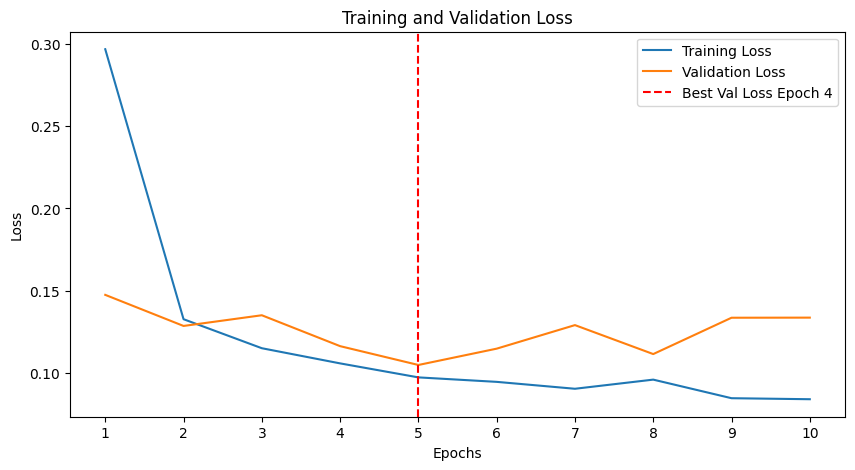

In [68]:
train_losses = []
validation_losses = []

best_loss = None
save_path = "../out/assignment01b/"
os.makedirs(save_path, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, optimizer, train_loader, criterion, idx=epoch)
    val_loss, val_accuracy = validate(model, validation_loader, criterion, idx=epoch)
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(save_path, "model.pt"))

plot_losses(train_losses, validation_losses)

In [69]:
model = ModernLeNet5(num_classes=11).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(save_path, "model.pt")))
model.eval()

ModernLeNet5(
  (leNet5): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=84, out_features=11, bias=True)
  )
)

In [70]:
test_loader = DataLoader(MNISTDataset(test_dataset), batch_size=BATCH_SIZE, shuffle=False)

no_detected_problematic = 0
no_correct_classifications = 0
problematic_bools = None
problematic_gt = None

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        images, labels = batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        prediction_classes = outputs.argmax(dim=1)
        no_detected_problematic += (prediction_classes == 10).sum().item()
        if problematic_bools is None:
            problematic_bools = (prediction_classes == 10).cpu()
        else:
            problematic_bools = torch.cat((problematic_bools, (prediction_classes == 10).cpu()), dim=0)
        if problematic_gt is None:
            problematic_gt = labels.cpu()
        else:
            problematic_gt = torch.cat((problematic_gt, labels.cpu()), dim=0)
        no_correct_classifications += (prediction_classes == labels).sum().item()

print(f"Number of detected problematic samples in test set: {no_detected_problematic/test_dataset.count() * 100:.2f}% ({no_detected_problematic} samples)")
print(f"Number of correct classifications (w/o problematic label) in test set: {no_correct_classifications/test_dataset.count() * 100:.2f}%")

Testing: 100%|██████████| 313/313 [00:03<00:00, 97.75it/s] 

Number of detected problematic samples in test set: 0.26% (26 samples)
Number of correct classifications (w/o problematic label) in test set: 98.80%


Note that this is not the test accuracy, as the 'problematic' class is included in the predictions but not in the ground truth labels. We could have defined a separate test set from the 60k curated dataset, but for simplicity we just use the original test set here. We expect that testing the model with a fully labeled test set including problematic samples would yield only minor insights, as the problematic samples are only a small fraction of the total dataset.

In [71]:
for sample, is_problematic in tqdm(zip(test_dataset, problematic_bools), desc="Tagging problematic samples in test set", total=test_dataset.count()):
    if is_problematic:
        sample.tags.append("problematic")
        sample.save()

Tagging problematic samples in test set:   0%|          | 0/10000 [00:00<?, ?it/s]

Tagging problematic samples in test set: 100%|██████████| 10000/10000 [00:01<00:00, 6104.54it/s]


In [72]:
problematic_view = test_dataset.match_tags("problematic")
session.view = problematic_view
session.refresh()

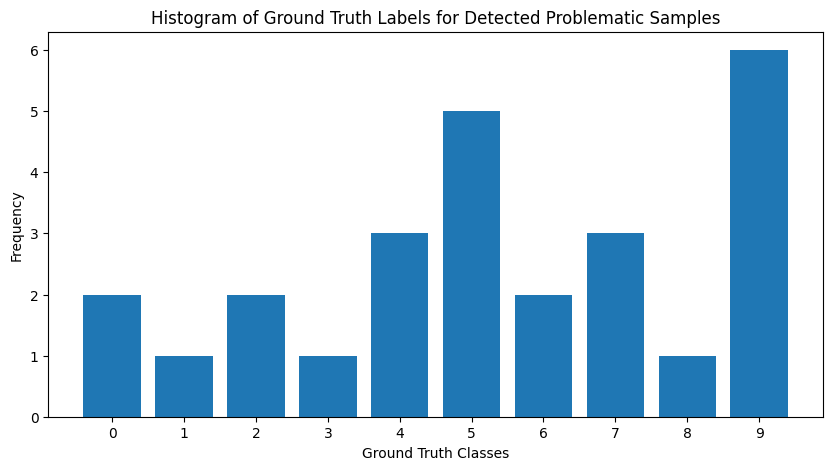

In [73]:
def histogram(data, title="Histogram", xlabel="Classes", ylabel="Frequency", xticks=None, xticks_labels=None, show_fun=None):
    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=np.arange(-0.5, len(xticks_labels) + 0.5, 1), align='mid', rwidth=0.8)
    if xticks is not None:
        plt.xticks(xticks, xticks_labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if show_fun is not None:
        show_fun(plt)
    else:
        plt.show()

histogram(problematic_gt[problematic_bools].numpy(), title="Histogram of Ground Truth Labels for Detected Problematic Samples", xlabel="Ground Truth Classes", ylabel="Frequency", xticks=list(range(10)), xticks_labels=[str(i) for i in range(10)])